Logged Out Succefullyly
Selected Track = Machine Learning


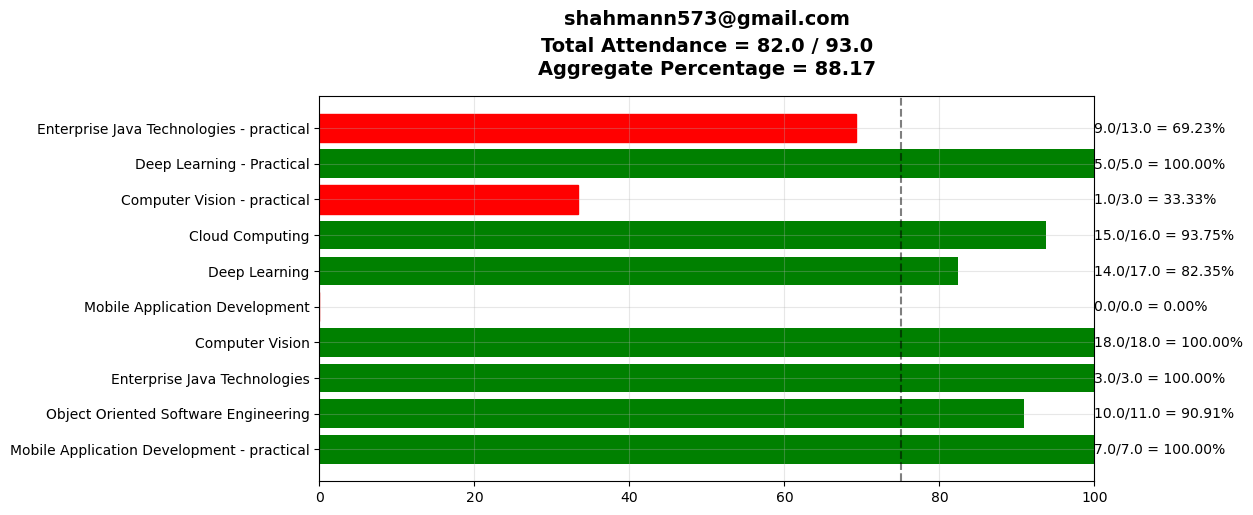

In [1]:
#!pip install pip install requests
#!pip install pandas
#!pip install matplotlib

import requests as rs
import pandas as pd
import matplotlib.pyplot as plt
import json



def json_decode(j_data):
    j_data=json.loads(j_data)
    # print(j_data)
    static_data={"course":j_data['attendanceDetails'][0]['_id'],
    "batch":j_data['attendanceDetails'][0]['batches'][0]['_id'],
    "division":j_data['attendanceDetails'][0]['batches'][0]['divisions'][0]['_id'],
    "semester":j_data['attendanceDetails'][0]['batches'][0]['divisions'][0]['semesters'][0]['_id']}


    small_dict={}
    for i in j_data['attendanceDetails'][0]['batches'][0]['divisions'][0]['semesters'][0]['subjects']:
        small_dict[i['subject']['name']]={"semesterSubject":i['_id'],"subject":i['subject']['_id']}

    payload={}
    for key, value in small_dict.items():
        payload[key] = {**static_data, **value}

    return payload


def show_data(data):
    plt.figure(figsize=[10, 5])
    bars = plt.barh(data.columns, data.loc['percentage'], color='green')

    for bar, total_present, total, percent in zip(bars, data.loc['totalPresent'], data.loc['total'],data.loc['percentage']):
        if percent<70:
            bar.set_color('red')
        elif percent<75:
            bar.set_color('orange')
        elif percent<80:
            bar.set_color('skyblue')

        plt.text(100, bar.get_y() + bar.get_height()/2, f'{total_present}/{total} = {percent:.2f}%', ha='left', va='center')

    plt.text(0.5, 1.20, login_data['email'], ha='center', va='center', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    #get curr axis,  gcf()->figure, axes coord-display coord
    plt.axvline(75,color='black',linestyle='--',alpha=0.5)

    tot_present = data.loc["totalPresent"].sum()
    tot_classes = data.loc['total'].sum()
    agg_percent = round((tot_present / tot_classes) * 100, 2)
    plt.text(0.5, 1.13, f"Total Attendance = {tot_present} / {tot_classes}", ha='center', va='center', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.5, 1.07, f"Aggregate Percentage = {agg_percent}", ha='center', va='center', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')

    plt.xlim(0,100)
    plt.grid(True, alpha=0.3)
    plt.show()


def fetch_data(urls):
    data={}
    with rs.Session() as s:
        response = s.post(urls["login_url"], data=login_data)
        if(response.status_code == 200):
            set_cookie_header = response.headers.get('Set-Cookie')
            token_start_index = set_cookie_header.find('token=') + len('token=')
            token_end_index = set_cookie_header.find(';', token_start_index)
            if token_end_index == -1:
                token = set_cookie_header[token_start_index:]
            else:
                token = set_cookie_header[token_start_index:token_end_index]

            header = {"Authorization": f"Bearer {token}"}
            payload=json_decode(s.get(urls["sub_url"],headers=header).content)

            jump=100//len(payload)
            count=jump
            for key in payload.keys():
                print(f'\rLoading... {count}%',end='',flush=True)
                att_data = s.post(urls["att_d_url"], json=payload[key], headers=header)
                data[key] = att_data.json()
                count+=jump

            print("\rData Fetched Succefully",end='',flush=True)
            lout=s.post(urls["lout_url"],headers=header,data={})
            if(lout.status_code==200):
                print("\rLogged Out Succefully",flush=True)
        else:
            print("Sorry Login Failed, Please Retry with Correct Credentials")
        s.close()
    return pd.DataFrame(data)


urls={"login_url": "https://attendence-system-1910.vercel.app/api/auth/login",
    "sub_url"  : "https://attendence-system-1910.vercel.app/api/attendances/details",
    "att_d_url" : "https://attendence-system-1910.vercel.app/api/students/attendances/details",
    "lout_url" : "https://attendence-system-1910.vercel.app/api/auth/logout"}

try:
    login_data={}
    login_data["email"]="shahmann573@gmail.com"
    login_data["password"]="Harry & 2"
    track=0
    data=fetch_data(urls)
    try:
        if track == 1:
            print("Selected Track = Web Designing")
            data.drop('Computer Vision',axis=1,inplace=True)
            data.drop('Deep Learning',axis=1,inplace=True)
            data.drop("Computer Vision - practical",axis=1,inplace=True)
            data.drop("Deep Learning - Practical",axis=1,inplace=True)
        elif track == 0:
            print("Selected Track = Machine Learning")
            data.drop('Web Security',axis=1,inplace=True)
            data.drop('Web Security - practical',axis=1,inplace=True)
            data.drop('Full Stack Web Development',axis=1,inplace=True)
            data.drop("Full Stack Web Development - practical",axis=1,inplace=True)
    except:
        print("Sorry Unable To Fetch Track Details, Going with Total")
    finally:
        show_data(data)
except:
    print("\n\nSorry to say Bro 😔😔😔, but Appko Hum Aage Badhne Nhi de Skte 😔😔😔")